In [1]:
from io import StringIO
from IPython.display import Image
import requests
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import json
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from shapely.geometry import Point

%matplotlib inline

## NSS Data Science Project 2 - Silver Sharks Geospatial API

### 1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
endpoint_mnpd = 'https://data.nashville.gov/resource/2u6v-ujjs.json'

In [3]:
params_mnpd = {
     'offense_description': 'BURGLARY- AGGRAVATED'
    ,'$where': "incident_reported between '2021-01-01T00:00:01.000' and '2021-06-30T23:59:59.000'"
    ,'$limit': '50000'
}

In [4]:
response_mnpd = requests.get(endpoint_mnpd, params = params_mnpd)

In [5]:
response_mnpd

<Response [200]>

In [6]:
response_mnpd.json()

[{'primary_key': '20210249540_11',
  'incident_number': '20210249540',
  'report_type': 'D',
  'report_type_description': 'DISPATCHED',
  'incident_status_code': 'O',
  'incident_status_description': 'OPEN',
  'investigation_status': 'Open',
  'incident_occurred': '2021-05-04T23:45:00.000',
  'incident_reported': '2021-05-05T00:45:00.000',
  'incident_location': 'UNIVERSITY CT',
  'latitude': '36.15',
  'longitude': '-86.77',
  'rpa': '8203',
  'zone': '511',
  'location_code': '22',
  'location_description': 'RESIDENCE, HOME',
  'offense_number': '1',
  'offense_nibrs': '220',
  'offense_description': 'BURGLARY- AGGRAVATED',
  'weapon_primary': '09',
  'weapon_description': 'PERSONAL (HANDS)',
  'victim_number': '1',
  'domestic_related': False,
  'victim_type': 'I',
  'victim_description': 'INDIVIDUAL (18 AND OVER)',
  'victim_gender': 'F',
  'victim_race': 'B',
  'victim_ethnicity': 'Non-Hispanic',
  'victim_county_resident': 'RESIDENT',
  'mapped_location': {'type': 'Point', 'coord

In [7]:
res = response_mnpd.json()
res = gpd.GeoDataFrame(res, columns=['incident_number','incident_reported',
                                 'offense_description','latitude','longitude','zip_code'])
res['date_reported'] = res['incident_reported'].str.split('T', expand=True)[0]
res_trimmed = res.drop(columns='incident_reported')
burglary_reports = res_trimmed[res_trimmed['offense_description'].str.contains('BURGLARY- AGGRAVATED')]

In [ ]:
# res_trimmed['offense_description'].unique()

In [8]:
burglary_reports

,incident_number,offense_description,latitude,longitude,zip_code,date_reported
0,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05
1,20210248840,BURGLARY- AGGRAVATED,36.2,-86.63,NaN,2021-05-04
2,20210244919,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02
3,20210244892,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02
4,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05
...,...,...,...,...,...,...
1046,20210029313,BURGLARY- AGGRAVATED,36.052,-86.647,37013,2021-01-16
1047,20210073787,BURGLARY- AGGRAVATED,36.152,-86.765,37210,2021-02-06
1048,20210127915,BURGLARY- AGGRAVATED,36.204,-86.807,37207,2021-03-05
1049,20210126551,BURGLARY- AGGRAVATED,36.05,-86.72,NaN,2021-03-03


In [9]:
burglary_reports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   incident_number      1051 non-null   object
 1   offense_description  1051 non-null   object
 2   latitude             1049 non-null   object
 3   longitude            1049 non-null   object
 4   zip_code             159 non-null    object
 5   date_reported        1051 non-null   object
dtypes: object(6)
memory usage: 57.5+ KB


In [10]:
# pd.to_numeric(burglary_reports['latitude'], errors='coerce') DOES NOT WORK FOR SOME REASON

burglary_reports[['latitude', 'longitude']] = burglary_reports[['latitude', 'longitude']].apply(pd.to_numeric)

In [ ]:
# TODO - OUTPUT STEP 1 TO CSV
# pd.burglary_reports.to_csv()

### 2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

By my calculations, Census Tract 163 had by far the highest number of burglaries with 53 (once we have eliminated duplicate incident numbers).

In [11]:
tract = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')

In [12]:
tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


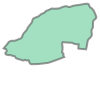

In [13]:
tract.loc[0, 'geometry']

In [14]:
print(tract.crs)

epsg:4269


In [15]:
tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1497 non-null   object  
 1   COUNTYFP  1497 non-null   object  
 2   TRACTCE   1497 non-null   object  
 3   GEOID     1497 non-null   object  
 4   NAME      1497 non-null   object  
 5   NAMELSAD  1497 non-null   object  
 6   MTFCC     1497 non-null   object  
 7   FUNCSTAT  1497 non-null   object  
 8   ALAND     1497 non-null   int64   
 9   AWATER    1497 non-null   int64   
 10  INTPTLAT  1497 non-null   object  
 11  INTPTLON  1497 non-null   object  
 12  geometry  1497 non-null   geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 152.2+ KB


In [16]:
tract.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [17]:
burglary_reports['geometry'] = burglary_reports.apply(lambda x: Point((x.longitude, 
                                                                       x.latitude)), 
                                                                       axis=1)
burglary_reports.head(3)

,incident_number,offense_description,latitude,longitude,zip_code,date_reported,geometry
0,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77 36.15)
1,20210248840,BURGLARY- AGGRAVATED,36.20,-86.63,NaN,2021-05-04,POINT (-86.63 36.2)
2,20210244919,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78 36.14)


In [18]:
burg_geo = gpd.GeoDataFrame(burglary_reports,
                            crs = tract.crs,
                            geometry = burglary_reports['geometry'])

In [19]:
type(burg_geo)

geopandas.geodataframe.GeoDataFrame

In [20]:
burgs_by_tract = gpd.sjoin(burg_geo,
                           tract,
                           op='within')

In [21]:
burgs_by_tract.head()

,incident_number,offense_description,latitude,longitude,zip_code,date_reported,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143
4,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143
63,20210187070,BURGLARY- AGGRAVATED,36.14,-86.76,NaN,2021-04-02,POINT (-86.76000 36.14000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143
129,20210006869,BURGLARY- AGGRAVATED,36.14,-86.76,NaN,2021-01-05,POINT (-86.76000 36.14000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143
158,20210223220,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-04-21,POINT (-86.77000 36.15000),652,47,037,016000,47037016000,160,Census Tract 160,G5020,S,1158914,0,+36.1454955,-086.7638143


In [22]:
burgs_by_tract.rename(columns = ({
                            'B01001_001E':    'population',
                            'S1901_C01_012E': 'median income'
                        })
                     , inplace=True)

In [23]:
burgs_by_tract.drop_duplicates(subset='incident_number', inplace=True)

In [24]:
burgs_by_tract.drop(['offense_description', 'latitude', 'longitude', 'date_reported', 
                     'index_right', 'STATEFP', 'GEOID', 'NAMELSAD', 'MTFCC', 
                     'FUNCSTAT','ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'zip_code'], 
                     axis=1, inplace=True)

In [25]:
burgs_by_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 826 entries, 0 to 1016
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   incident_number  826 non-null    object  
 1   geometry         826 non-null    geometry
 2   COUNTYFP         826 non-null    object  
 3   TRACTCE          826 non-null    object  
 4   NAME             826 non-null    object  
dtypes: geometry(1), object(4)
memory usage: 38.7+ KB


In [26]:
# THIS NUMBER CHANGES AFTER ELIMINATING COLUMNS FROM THE DATA FRAME

burgs_by_tract['NAME'].value_counts()\
                      .nlargest(5)

163       53
162       21
110.01    20
195       19
193       19
Name: NAME, dtype: int64

In [ ]:
# TODO - OUTPUT STEP 2 TO CSV
# pd.burgs_by_tract.to_csv()

### 3. For this part, you'll need to request a [census API key](https://api.census.gov/data/key_signup.html). Using the [2019 American Community Survey API](https://www.census.gov/data/developers/data-sets/acs-5year.html), obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.

In [27]:
# with open('../data/cens_api.json') as f:
#   credentials = json.load(f)
#
# api_key = credentials['api_key']

In [28]:
endpoint_pop = "https://api.census.gov/data/2019/acs/acs5"
params_pop = {
       'get' : 'NAME,B01001_001E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : 
                # TODO - FIX API_KEY FILE - USING A HARD-CODED API KEY AT THE MOMENT
}               # - DOES EMACS NEED EXTRA TWEAKING TO CREATE JSON FILES PROPERLY?

endpoint_income = "https://api.census.gov/data/2019/acs/acs5/subject"
params_income = {
       'get' : 'NAME,S1901_C01_012E',
       'for' : 'tract:*',
       'in'  : ['state:47', 'county:037'],
       'key' : 
}

response_pop = requests.get(endpoint_pop, params=params_pop)

response_income = requests.get(endpoint_income, params=params_income)

res_pop = response_pop.json()
population = pd.DataFrame(res_pop)
#changes column names
population.columns = population.iloc[0]
population = population[1:]
display(population.head())

res_income = response_income.json()
med_income = pd.DataFrame(res_income) 
#changes colum names 
med_income.columns = med_income.iloc[0]
med_income = med_income[1:]
display(med_income.head())

,NAME,B01001_001E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",12176,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",4098,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",2466,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",5210,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",8254,47,037,018301


,NAME,S1901_C01_012E,state,county,tract
1,"Census Tract 156.31, Davidson County, Tennessee",75579,47,037,015631
2,"Census Tract 158.04, Davidson County, Tennessee",45129,47,037,015804
3,"Census Tract 177.01, Davidson County, Tennessee",134786,47,037,017701
4,"Census Tract 177.02, Davidson County, Tennessee",107813,47,037,017702
5,"Census Tract 183.01, Davidson County, Tennessee",87591,47,037,018301


In [ ]:
# population.info()

In [ ]:
# med_income.info()

In [29]:
pop_inc = pd.merge(left=population, 
                   right=med_income,
                   on='tract')

In [30]:
pop_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 160
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   NAME_x          161 non-null    object
 1   B01001_001E     161 non-null    object
 2   state_x         161 non-null    object
 3   county_x        161 non-null    object
 4   tract           161 non-null    object
 5   NAME_y          161 non-null    object
 6   S1901_C01_012E  161 non-null    object
 7   state_y         161 non-null    object
 8   county_y        161 non-null    object
dtypes: object(9)
memory usage: 12.6+ KB


In [31]:
pop_inc.drop(['NAME_y', 'state_y', 'state_x', 'county_y'], 
               axis=1, 
               inplace=True)

In [32]:
pop_inc.rename(columns = ({
                            'B01001_001E':    'population',
                            'S1901_C01_012E': 'median income'
                        })
                     , inplace=True)

In [33]:
pop_inc = pop_inc.set_index('NAME_x')

In [34]:
pop_inc.head()

,population,county_x,tract,median income
NAME_x,,,,
"Census Tract 156.31, Davidson County, Tennessee",12176,037,015631,75579
"Census Tract 158.04, Davidson County, Tennessee",4098,037,015804,45129
"Census Tract 177.01, Davidson County, Tennessee",2466,037,017701,134786
"Census Tract 177.02, Davidson County, Tennessee",5210,037,017702,107813
"Census Tract 183.01, Davidson County, Tennessee",8254,037,018301,87591


In [35]:
burgs_with_pop_inc = pd.merge(left=burgs_by_tract, right=pop_inc,
                              left_on='TRACTCE', right_on='tract')

In [36]:
burgs_with_pop_inc.head()

,incident_number,geometry,COUNTYFP,TRACTCE,NAME,population,county_x,tract,median income
0,20210249540,POINT (-86.77000 36.15000),037,016000,160,945,037,016000,37083
1,20210187070,POINT (-86.76000 36.14000),037,016000,160,945,037,016000,37083
2,20210006869,POINT (-86.76000 36.14000),037,016000,160,945,037,016000,37083
3,20210223220,POINT (-86.77000 36.15000),037,016000,160,945,037,016000,37083
4,20210013709,POINT (-86.76000 36.14000),037,016000,160,945,037,016000,37083


In [ ]:
# PUT THE CALCULATIONS IN STEP 4 - MERGE THE POPULATION DATA FIRST
# burgs_row_ct = pd.DataFrame(burgs_by_tract['TRACTCE'].value_counts())

In [ ]:
# burgs_row_ct = burgs_row_ct.rename(columns={'TRACTCE': 'Burglary count'})

In [ ]:
# burgs_row_ct = burgs_row_ct.drop_duplicates()

In [ ]:
# burgs_row_ct.info()

In [38]:
burg_counts = pd.merge(left = pop_inc, right = burgs_row_ct,
                       left_on='tract', right_on = 'TRACTCE')

NameError: name 'burgs_row_ct' is not defined

In [37]:
burg_counts

NameError: name 'burg_counts' is not defined

In [ ]:
# pop_inc.drop_duplicates(subset='geometry', inplace=True)

In [ ]:
# TODO - SAVE STEP 3 TO CSV
# pd.to_csv(burgs_pop_med)

### 4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [ ]:
burgs_row_ct = pd.DataFrame(burgs_pop_med['NAME'].value_counts())

In [ ]:
burgs_row_ct = burgs_row_ct.rename(columns={'NAME': 'Burglary count'})

In [ ]:
burgs_row_ct = burgs_row_ct.drop_duplicates()

In [ ]:
burgs_pop_inc = pd.DataFrame(burgs_pop_med[['NAME', 'population', 'median income']])

In [ ]:
burgs_pop_inc = burgs_pop_inc.set_index('NAME')

In [ ]:
burgs_row_ct.columns

In [ ]:
burgs_row_ct.columns

In [ ]:
burgs_pop_inc 

In [ ]:
burg_counts = pd.merge(left = burgs_row_ct, right = burgs_pop_inc,
                       on='NAME')

In [ ]:
burg_counts

In [ ]:
# EACH TRACT'S POPULATION (IN 1000s)
burgs_pop_med['pop_1000'] = burgs_pop_med['population']/1000

In [ ]:
# EACH TRACT'S POPULATION (IN 1000s)
burgs_pop_med['population'].unique()

In [ ]:
# burgs_pop_med[burgs_pop_med.groupby('NAME')]['population']
burgs_pop_med(['NAMELSAD', 'population'])

In [ ]:
# ADDING CALCULATED COLUMN - BURGLARIES PER 1000 RESIDENTS PER TRACT
burgs_pop_med['NAMELSAD'].value_counts() # / 

In [ ]:
'''
fig, ax = plt.subplots(figsize=(16,8))
dav.plot(ax = ax)
ax.axis('off');

--OR--

fig, ax = plt.subplots(figsize=(16,4))
census.plot(column = 'unemployment_rate', 
              cmap = 'GnBu', 
              edgecolor = 'black', 
              legend = True,
              ax = ax)
plt.title('Burglary rate per 1000 residents', fontsize = 14)
ax.axis('off');
'''

### 5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the [Generalized Linear Models](https://www.statsmodels.org/stable/glm.html) module of the statsmodels library.

### a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.)

### b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

### c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out [this tutorial](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/).

### d. How do your models compare? Hint: the fit models have an AIC attribute.

### 6. Prepare a short presentation (<10 minutes) of your findings.